In [1]:
# Practice Skills: Random forest and gradient boosting

# Goal: It is your job to predict the sales price for each house (SalePrice)

# Metric: Submissions are evaluated on RMSE between the logarithm of the 
## predicted value and the logarithm of the observed sales price.

# Submission format.

# Study guides:
# https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset
# https://www.kaggle.com/mgmarques/houses-prices-complete-solution
# https://medium.com/diogo-menezes-borges/project-2-predicting-house-prices-on-kaggle-989f1b0c4ef6
# https://www.kaggle.com/agodwinp/stacking-house-prices-walkthrough-to-top-5
# https://github.com/itsmuriuki/Predicting-House-prices/blob/master/house%20prices%20prediction.ipynb

# Dummy variables:
# https://www.youtube.com/watch?v=9yl6-HEY7_s
# https://www.youtube.com/watch?v=0s_1IsROgDc

# Categorical data:
# https://www.datacamp.com/community/tutorials/categorical-data

# Missing values:
# https://towardsdatascience.com/the-tale-of-missing-values-in-python-c96beb0e8a9d
# https://towardsdatascience.com/how-to-handle-missing-data-8646b18db0d4

# 1) Preparing the environment and uploading the data:

In [95]:
# Importing the libraries:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import csv
import seaborn as sns
import statsmodels.api as sm
from scipy import stats 
from scipy.stats import skew
from scipy.special import boxcox1p
# import sklearn.cross_validation as cv
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV, ElasticNetCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import LabelBinarizer # separate variable into binary categories
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")

pd.options.display.max_columns = 999 #To visualize the whole grid of columns

In [3]:
# Importing datasets:
train = pd.read_csv(r"C:\Users\rafae\Desktop\Code\Machine Learning\Kaggle - House Prices/train.csv")
print("Train data (rows, columns): " + str(train.shape))
df_train = pd.DataFrame(train)

test = pd.read_csv(r"C:\Users\rafae\Desktop\Code\Machine Learning\Kaggle - House Prices/test.csv")
print("Test data (rows, columns): " + str(test.shape))
df_test = pd.DataFrame(test)

# Dropping columns with missing, useless or repeated data:
### df_train.drop(columns=df_train["Utilities"], inplace=True)
### df_test.drop(columns=df_test["Utilities"], inplace=True)

Train data (rows, columns): (1460, 81)
Test data (rows, columns): (1459, 80)


# 2.1) Exploratory data analysis (general):

In [5]:
# A first look at the data:
# https://www.kaggle.com/mgmarques/houses-prices-complete-solution

def rstr(df, pred=None): 
    obs = df.shape[0]
    types = df.dtypes
    counts = df.apply(lambda x: x.count())
    nulls = df.apply(lambda x: x.isnull().sum())
    distincts = df.apply(lambda x: x.unique().shape[0])
    missing_ration = (df.isnull().sum()/ obs) * 100
    skewness = df.skew()
    kurtosis = df.kurt() 
    print('Data shape:', df.shape)
    
    if pred is None:
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing ration', 'skewness', 'kurtosis']
        str = pd.concat([types, counts, distincts, nulls, missing_ration, skewness, kurtosis], axis = 1)

    else:
        corr = df.corr()[pred]
        str = pd.concat([types, counts, distincts, nulls, missing_ration, skewness, kurtosis, corr], axis = 1, sort=False)
        corr_col = 'corr '  + pred
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing_ration', 'skewness', 'kurtosis', corr_col ]
        
    str.columns = cols
    dtypes = str.types.value_counts()
    print('___________________________\nData types:\n',str.types.value_counts())
    print('___________________________')
    return str

pd.set_option('display.max_rows', 90)
details = rstr(df_train, 'SalePrice')
display(details.sort_values(by='corr SalePrice', ascending=False))

Data shape: (1452, 81)
___________________________
Data types:
 object     43
int64      35
float64     3
Name: types, dtype: int64
___________________________


,types,counts,distincts,nulls,missing_ration,skewness,kurtosis,corr SalePrice
SalePrice,int64,1452,658,0,0.000000,1.578456,3.962323,1.000000
OverallQual,int64,1452,10,0,0.000000,0.184821,0.049211,0.802832
GrLivArea,int64,1452,855,0,0.000000,0.841829,1.000040,0.720183
GarageCars,int64,1452,5,0,0.000000,-0.340623,0.220201,0.650498
TotalBsmtSF,int64,1452,714,0,0.000000,0.487770,1.780763,0.643992
GarageArea,int64,1452,437,0,0.000000,0.134470,0.773334,0.638284
1stFlrSF,int64,1452,745,0,0.000000,0.873648,1.105284,0.622602
FullBath,int64,1452,4,0,0.000000,0.022923,-0.896720,0.558330
TotRmsAbvGrd,int64,1452,12,0,0.000000,0.663044,0.879403,0.538858
YearBuilt,int64,1452,112,0,0.000000,-0.611115,-0.446811,0.538204


In [ ]:
# Statistical analysis of the numerical data:

display(df_train.describe().transpose())

In [ ]:
# Data visualization:

df_train.info()

In [ ]:
# Printing all the columns from the origianl dataframe:

df_test.columns

In [ ]:
# Checking for duplicates in the data:

# idsUnique = len(set(df_train.Id))
# idsTotal = df_train.shape[0]
# idsDupli = idsTotal - idsUnique
# print("There are " + str(idsDupli) + " duplicate IDs for " + str(idsTotal) + " total entries")

In [ ]:
# Code for checking the results of the droppage of missing values:

# df_train.drop(columns=[""])[:3]

In [ ]:
# Code for finding numeric values:

# numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
# newdf = df_train.select_dtypes(include=numerics)
# newdf.columns

In [ ]:
# Code for finding object values:

# objects = ['object']
# newdf2 = df_train.select_dtypes(include=objects)
# newdf2.columns

In [ ]:
# Analysis of Outliers: Interquartile range (IQR):
# https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba

# Q1 = df_train.quantile(0.25)
# Q3 = df_train.quantile(0.75)
# IQR = Q3 - Q1
# print(IQR)

In [ ]:
# Graph the correlation between two variables:
# plt.figure(figsize=(12,7))
# plt.xlabel("YearBuilt")
# plt.ylabel("GarageYrBlt")
# plt.plot(df_train.YearBuilt, df_train.GarageYrBlt,'.', alpha=0.5, label = 'training set')
# plt.plot(df_test.YearBuilt, df_test.GarageYrBlt,'.', alpha=0.5, label = 'test set') 
# plt.legend()

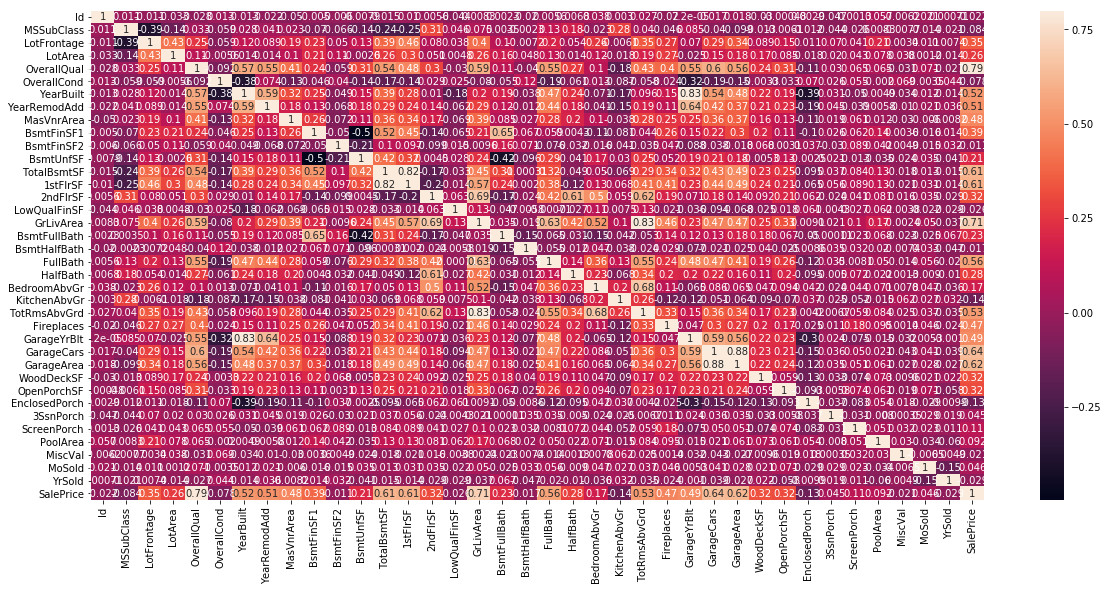

In [4]:
# Correlation Matrix:

corr = df_train.corr()
f, ax = plt.subplots(figsize=(20, 9))
sns.heatmap(corr, vmax=.8,annot_kws={'size': 10}, annot=True);
plt.show();

# 2.2) Exploratory data analysis (specific):

# Log transformation of skewed values:

In [6]:
# https://github.com/itsmuriuki/Predicting-House-prices/blob/master/house%20prices%20prediction.ipynb
# https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset

# Log transformation of skewed numeric features: 
numeric_features = df_train.dtypes[df_train.dtypes != "object"].index

skewed_features = df_train[numeric_features].apply(lambda x : skew (x.dropna())).sort_values(ascending=False)

# Compute skewness
print ("Skew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_features})   
skewness.head(38)

Skew in numerical features: 



,Skew
PoolArea,14.363418
3SsnPorch,7.827826
LowQualFinSF,7.593301
MiscVal,5.505530
KitchenAbvGr,3.995746
BsmtHalfBath,3.943685
ScreenPorch,3.184431
BsmtFinSF2,2.619350
EnclosedPorch,2.160966
LotArea,0.751948


In [7]:
skewness = skewness[abs(skewness) > 0.75]
print ("There are {} skewed numerical features to box cox transform".format(skewness.shape[0]))

skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    df_train[feat] = boxcox1p(df_train[feat], lam)

There are 38 skewed numerical features to box cox transform


# Removing outliers:


In [4]:
# Removing outliers according to the article and some others:

# GrLivArea outliers: 523, 691, 1182, 1298
# LotArea outliers: 249, 313, 335, 706
# BsmtFinSF1: 1298
# TotalBsmtSF: 1298
# 1stFlrSF: 1298

deleting_outliers = df_train.drop([df_train.index[1298], df_train.index[1182],
                                   df_train.index[706], df_train.index[691], 
                                   df_train.index[523], df_train.index[335], 
                                   df_train.index[313], df_train.index[249]], 
                                  inplace=True)

deleting_outliers = df_test.drop([df_test.index[1298], df_test.index[1182],
                                   df_test.index[706], df_test.index[691], 
                                   df_test.index[523], df_test.index[335], 
                                   df_test.index[313], df_test.index[249]], 
                                  inplace=True)

df_train.loc[df_train["GrLivArea"] > 4000]
df_train.loc[df_train["LotArea"] > 100000]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


# Id:

In [5]:
# "Id": 
# It must be deleted.

# Saving the 'Id' column:
# df_train_ID = df_train['Id']
# df_test_ID = df_test['Id']

df_train.drop(["Id"], axis = 1, inplace = True)
df_test.drop(["Id"], axis = 1, inplace = True)

### Ok. Useless feature for the test. Drop.

# MsSubClass:

In [6]:
# "MSSubClass": 
# The building class.
# It is a category besides being numeric.
# Correlation: -0.084284

# sns.boxplot(x="MSSubClass", y="SalePrice", data=df_train, palette="pastel")

# print(df_train['MSSubClass'].value_counts())

df_train["MSSubClassLog"] = np.log1p(df_train.MSSubClass)
df_test["MSSubClassLog"] = np.log1p(df_test.MSSubClass)

df_train["SalePrice"].corr(df_train["MSSubClassLog"]) # -0.034217222354024635

df_train.drop(["MSSubClass"], axis = 1, inplace = True)
df_test.drop(["MSSubClass"], axis = 1, inplace = True)

df_train = pd.get_dummies(df_train, columns=["MSSubClassLog"], drop_first=True)
df_test = pd.get_dummies(df_test, columns=["MSSubClassLog"], drop_first=True)

### Ok. Many different categorical values with many incidences. Create dummies.

# MSZoning:

In [7]:
# 'MSZoning': 5 types of categories.
# The general zoning classification.
# It has no specific order.

# sns.boxplot(x="MSZoning", y="SalePrice", data=df_train, palette="pastel")

# df_train['MSZoning'].value_counts() # RL = 1151 values.

df_train = pd.get_dummies(df_train, columns=["MSZoning"])
df_test = pd.get_dummies(df_test, columns=["MSZoning"])

df_train.drop(["MSZoning_RM"], axis = 1, inplace = True)
df_test.drop(["MSZoning_RM"], axis = 1, inplace = True)

### Ok. Is there any column that should be dropped for being an outlier or insignificant?

# LotFrontage:

In [8]:
# "LotFrontage": 111 types of numbers.
# Linear feet of street connected to property.
# Correlation: 0.351799

# sns.jointplot(x="LotFrontage", y="SalePrice", data=df_train, kind="reg", height=5, ratio=3)

df_train["LotFrontage"].fillna(0, inplace=True) # Size to 0 or average?
df_test["LotFrontage"].fillna(0, inplace=True) # Size to 0 or average?

# print(df_train["LotFrontage"].skew()) # -1.69733588894

### Ok. Delete outliers?

# LotArea:

In [9]:
# "LotArea": 1073 types of numbers.
# Correlation: 0.263843

# sns.jointplot(x="LotArea", y="SalePrice", data=df_train, kind="reg", height=5, ratio=3)

# print(df_train["LotArea"].skew()) = # -1.11574680301

df_train["LotAreaLog"] = np.log1p(df_train.LotArea)
df_test["LotAreaLog"] = np.log1p(df_test.LotArea)

# df_train["SalePrice"].corr(df_train["LotAreaLog"]) # 0.38852838242409876

df_train.drop(["LotArea"], axis = 1, inplace = True)
df_test.drop(["LotArea"], axis = 1, inplace = True)

### Ok. Positive correlation to SalePrice. 4 Outliers removed. Log.

# Street:

In [10]:
# 'Street': 2 types of categories.
# Mostly redundant, as most streets are basically "Pave". Only 5 are "Grvl".

# sns.jointplot(x="Street", y="SalePrice", data=df_train, height=5, ratio=3)

# df_train['Street'].value_counts() # Pave = 1454.

df_train.drop(["Street"], axis = 1, inplace = True)
df_test.drop(["Street"], axis = 1, inplace = True)

### Ok. Drop for being irrelevant.

# Alley:

In [11]:
# 'Alley': 3 types of categories.
# Type of alley access.

# sns.boxplot(x="Alley", y="SalePrice", data=df_train, palette="pastel")

# df_train["Alley"].value_counts() # No = 1369.

# df_train["Alley"].fillna("No", inplace=True)
# df_test["Alley"].fillna("No", inplace=True)

df_train.drop(["Alley"], axis = 1, inplace = True)
df_test.drop(["Alley"], axis = 1, inplace = True)

### Ok. Mostly useless data. Drop.

# LotShape:

In [12]:
# 'LotShape': 4 types of categories.
# General shape of property.

# Reg Regular 
# IR1 Slightly irregular
# IR2 Moderately Irregular
# IR3 Irregular

# result = df_train.groupby(["LotShape"])['SalePrice'].aggregate(np.median).reset_index().sort_values('SalePrice')
# sns.catplot(x="LotShape", y="SalePrice", kind="box", data=df_train, order=result["LotShape"]);

# df_train['LotShape'].value_counts()

df_train = df_train.replace({"LotShape" : {"Reg" : 4, "IR1" : 3, "IR2" : 2, 
                                           "IR3" : 1}})  
df_test = df_test.replace({"LotShape" : {"Reg" : 4, "IR1" : 3, "IR2" : 2, 
                                         "IR3" : 1}})  

### Ok. It has a linear relationship with SalePrice.

# LandContour:

In [13]:
# 'LandContour': 4 types of categories.
# Flatness of the property

# sns.catplot(x="LandContour", y="SalePrice", kind="box", data=df_train);

# df_train["LandContour"].value_counts()

df_train = pd.get_dummies(df_train, columns=["LandContour"])
df_test = pd.get_dummies(df_test, columns=["LandContour"])

df_train.drop(["LandContour_Low"], axis = 1, inplace = True)
df_test.drop(["LandContour_Low"], axis = 1, inplace = True)

### Ok. Categorical with no order. Dummy.

# Utilities:

In [14]:
# 'Utilities': 2 types of categories.

# sns.catplot(x="Utilities", y="SalePrice", kind="box", data=df_train);

# df_train['Utilities'].value_counts()

df_train.drop(['Utilities'], axis = 1, inplace=True)
df_test.drop(['Utilities'], axis = 1, inplace=True)

# Ok. All the same. Drop.

# LotConfig:

In [15]:
# 'LotConfig': 5 types of categories.
# Lot configuration.

# sns.catplot(x="LotConfig", y="SalePrice", kind="box", data=df_train);

# df_train["LotConfig"].value_counts()

df_train = pd.get_dummies(df_train, columns=["LotConfig"])
df_test = pd.get_dummies(df_test, columns=["LotConfig"])

df_train.drop(["LotConfig_FR2"], axis = 1, inplace = True)
df_test.drop(["LotConfig_FR2"], axis = 1, inplace = True)

### Ok. Categorical without order. Cluster FR2 and FR3. Dummy.

# LandSlope:

In [16]:
# 'LandSlope': 3 types of categories.
# Slope of property.

# Gtl Gentle slope
# Mod Moderate Slope  
# Sev Severe Slope
    
# sns.catplot(x="LandSlope", y="SalePrice", data=df_train);

# df_train["LandSlope"].value_counts() # Gtl: 1382 numbers.

df_train = df_train.replace({"LandSlope" : {"Grl" : 3, "Mod" : 2, "Sev" : 1}})
df_test = df_test.replace({"LandSlope" : {"Grl" : 3, "Mod" : 2, "Sev" : 1}})

df_train['LandSlope'] = pd.to_numeric(df_train['LandSlope'], errors='coerce').fillna(0).astype(int)

### Ok.

# Neighborhood:

In [17]:
# 'Neighborhood': 25 types of categories.
# Physical locations within Ames city limits.

# Graph:
# result = df_train.groupby(["Neighborhood"])['SalePrice'].aggregate(np.median).reset_index().sort_values('SalePrice')
# plt.figure(figsize=(8,6))
# sns.stripplot(x = df_train.Neighborhood, y = df_train.SalePrice,
#               order=result["Neighborhood"],jitter=0.1, alpha=0.5)
# plt.xticks(rotation=45)

# df_train["Neighborhood"].value_counts()

df_train = pd.get_dummies(df_train, columns=["Neighborhood"])
df_test = pd.get_dummies(df_test, columns=["Neighborhood"])

df_train.drop(["Neighborhood_Blueste"], axis = 1, inplace = True)
df_test.drop(["Neighborhood_Blueste"], axis = 1, inplace = True)

### Ok. Some neighborhoods are more expensive than others.

# Condition1:

In [18]:
# 'Condition1': 9 types of categories.
# Proximity to various conditions.

# result = df_train.groupby(["Condition1"])['SalePrice'].aggregate(np.median).reset_index().sort_values('SalePrice')
# sns.catplot(x="Condition1", y="SalePrice", kind="box", data=df_train, order=result["Condition1"]);

# df_train["Condition1"].value_counts() # Norm = 1260.

df_train = df_train.replace({"Condition1" : {"Feedr" : "Other", "Artery" : "Other",
                                            "RRAn" : "Other", "PosN" : "Other", 
                                            "RRAe" : "Other", "PosA" : "Other",
                                            "RRNn" : "Other", "RRNe" : "Other"}
                     })

df_test = df_test.replace({"Condition1" : {"Feedr" : "Other", "Artery" : "Other",
                                            "RRAn" : "Other", "PosN" : "Other", 
                                            "RRAe" : "Other", "PosA" : "Other",
                                            "RRNn" : "Other", "RRNe" : "Other"}
                     })

df_train = pd.get_dummies(df_train, columns=["Condition1"])
df_test = pd.get_dummies(df_test, columns=["Condition1"])

df_train.drop(["Condition1_Other"], axis = 1, inplace = True)
df_test.drop(["Condition1_Other"], axis = 1, inplace = True)

### Ok. Most values are Norm, and the rest of the values remain in a similar band.
### So, create a cluster for the rest, and create dummies for both.

# Condition2:

In [19]:
# 'Condition2': 8 types of categories.
# Proximity to various conditions.

# result = df_train.groupby(["Condition2"])['SalePrice'].aggregate(np.median).reset_index().sort_values('SalePrice')
# sns.catplot(x="Condition2", y="SalePrice", kind="box", data=df_train, order=result["Condition2"]);

# df_train["Condition2"].value_counts() # Norm = 1445.

df_train.drop(["Condition2"], axis = 1, inplace=True)
df_test.drop(["Condition2"], axis = 1, inplace=True)

### Ok. 1445 values are Norm. Drop.

# BldgType:

In [20]:
# 'BldgType': 5 types of categories.
# Type of dwelling.

# sns.catplot(x="BldgType", y="SalePrice", kind="box", data=df_train);

# df_train["BldgType"].value_counts()

df_train = pd.get_dummies(df_train, columns=["BldgType"])
df_test = pd.get_dummies(df_test, columns=["BldgType"])

df_train.drop(["BldgType_2fmCon"], axis = 1, inplace = True)
df_test.drop(["BldgType_2fmCon"], axis = 1, inplace = True)

### Ok. Categorical without order. Dummy.

# HouseStyle:

In [21]:
# 'HouseStyle': 8 types of categories.
# Style of dwelling.

# sns.catplot(x="HouseStyle", y="SalePrice", kind="box", data=df_train);

# df_train["HouseStyle"].value_counts()

df_train = pd.get_dummies(df_train, columns=["HouseStyle"])
df_test = pd.get_dummies(df_test, columns=["HouseStyle"])

df_train.drop(["HouseStyle_2.5Unf"], axis = 1, inplace = True)
df_test.drop(["HouseStyle_2.5Unf"], axis = 1, inplace = True)

### Ok. Many categories with fewer values. Cluster? How? Dummy.

# OverallQual:

In [22]:
# 'OverallQual': 10 types of numbers.
# Rates the overall material and finish of the house.
# Correlation: 0.790982

# sns.jointplot(x="OverallQual", y="SalePrice", data=df_train, kind="reg", height=5, ratio=3)
# sns.boxplot(x="OverallQual", y="SalePrice", data=df_train, palette="pastel")

### Ok. Strongly correlated with SalePrice. Ordinal. Maintain it as it is.

# OverallCond:

In [23]:
# 'OverallCond': 9 types of numbers.
# Rates the overall condition of the house.
# Correlation: -0.077856

# result = df_train.groupby(["OverallCond"])['SalePrice'].aggregate(np.median).reset_index().sort_values('SalePrice')
# sns.catplot(x="OverallCond", y="SalePrice", kind="box", data=df_train, order=result["OverallCond"]);

# df_train["OverallCond"].value_counts()

### ??? Ordinal feature, but it is not properly organized. Should I reorganize it in
### the proper order? ???

# YearBuilt:

In [24]:
# "YearBuilt": 112 types of categories/numbers (dates).
# Original construction date.
# Correlation: 0.522897

# sns.catplot(x="YearBuilt", y="SalePrice", kind="box", data=df_train);

### Ok. The newer or the older the house, the higher the correlation to SalesPrice.
### Maintain it as it is. ???

# YearRemodAdd:

In [25]:
# "YearRemodAdd": 61 types of categories/numbers (dates).
# Remodel date (same as construction date if no remodeling or additions).
# Correlation: 0.507101

# sns.catplot(x="YearRemodAdd", y="SalePrice", kind="box", data=df_train);

### Ok. The newer the remodelling of a house, the higher the correlation to 
### SalesPrice. Maintain it as it is.

# RoofStyle:

In [26]:
# "RoofStyle": 6 types of categories.
# Type of roof.

# sns.catplot(x="RoofStyle", y="SalePrice", kind="box", data=df_train);

# df_train["RoofStyle"].value_counts()

df_train = pd.get_dummies(df_train, columns=["RoofStyle"])
df_test = pd.get_dummies(df_test, columns=["RoofStyle"])

df_train.drop(["RoofStyle_Shed"], axis = 1, inplace = True)
df_test.drop(["RoofStyle_Shed"], axis = 1, inplace = True)

### Ok. Categorical without order. Dummies.

# RoofMatl:

In [27]:
# "RoofMatl": 8 types of categories.
# Roof material.

# sns.catplot(x="RoofMatl", y="SalePrice", kind="box", data=df_train);

# df_train["RoofMatl"].value_counts() # CompShg: 1434 values.

df_train = pd.get_dummies(df_train, columns=["RoofMatl"])
df_test = pd.get_dummies(df_test, columns=["RoofMatl"])

df_train.drop(["RoofMatl_WdShngl"], axis = 1, inplace = True)
df_test.drop(["RoofMatl_WdShngl"], axis = 1, inplace = True)

### Ok. Most features have almost no observations. Drop? ???

# Exterior1st:

In [28]:
# "Exterior1st": 15 types of categories. 
# Exterior covering on house.

# sns.catplot(x="Exterior1st", y="SalePrice", kind="box", data=df_train);

# df_train["Exterior1st"].value_counts()

df_train = pd.get_dummies(df_train, columns=["Exterior1st"])
df_test = pd.get_dummies(df_test, columns=["Exterior1st"])

df_train.drop(["Exterior1st_CemntBd"], axis = 1, inplace = True)
df_test.drop(["Exterior1st_CemntBd"], axis = 1, inplace = True)

### Ok. Dummy.

# Exterior2nd:

In [29]:
# "Exterior2nd": 16 types of categories.
# Exterior covering on house.

# sns.catplot(x="Exterior2nd", y="SalePrice", kind="box", data=df_train);

# df_train["Exterior2nd"].value_counts()

df_train.drop(["Exterior2nd"], axis = 1, inplace=True)
df_test.drop(["Exterior2nd"], axis = 1, inplace=True)

### Ok. Extremely similar/correlated to Exterior1st. Dropped.

# MasVnrType:

In [30]:
# "MasVnrType": 5 types of categories.
# Masonry veneer type.

# sns.catplot(x="MasVnrType", y="SalePrice", kind="box", data=df_train);

# df_train["MasVnrType"].value_counts()

df_train.drop(["MasVnrType"], axis = 1, inplace=True)
df_test.drop(["MasVnrType"], axis = 1, inplace=True)

### Ok. Categorical without order. Create dummies. Drop this instead of MasVnrArea,
### given the other is numerical.

# MasVnrArea:

In [31]:
# "MasVnrArea": 328 types of numbers.
# Masonry veneer area in square feet.
# Correlation: 0.477493

# sns.jointplot(x="MasVnrArea", y="SalePrice", data=df_train, kind="reg", height=5, ratio=3)

# df_train["MasVnrArea"].value_counts()

df_train["MasVnrArea"].fillna(0, inplace=True) # Area to 0.
df_test["MasVnrArea"].fillna(0, inplace=True) # Area to 0.

df_train["MasVnrAreaLog"] = np.log1p(df_train.MasVnrArea)
df_test["MasVnrAreaLog"] = np.log1p(df_test.MasVnrArea)

# df_train["SalePrice"].corr(df_train["MasVnrAreaLog"])

df_train.drop(["MasVnrArea"], axis = 1, inplace = True)
df_test.drop(["MasVnrArea"], axis = 1, inplace = True)

### Ok. High correlation with SalesPrice. More than half the data is 0.
### Although, high correlation with MasVnrType. Drop the other.

# ExterQual:

In [32]:
# "ExterQual": 4 types of categories.
# Evaluates the quality of the material on the exterior.

# Ex Excellent
# Gd Good
# TA Average/Typical
# Fa Fair
# Po Poor
    
# result = df_train.groupby(["ExterQual"])['SalePrice'].aggregate(np.median).reset_index().sort_values('SalePrice')
# sns.catplot(x="ExterQual", y="SalePrice", kind="box", data=df_train, order=result["ExterQual"]);

# df_train["ExterQual"].value_counts()
# df_train['ExterQual'].isna().sum() = 0.

df_train = df_train.replace({"ExterQual" : {"Ex" : 5, "Gd" : 4, "TA": 3, 
                                            "Fa": 2, "Po" : 1}})  
df_test = df_test.replace({"ExterQual" : {"Ex" : 5, "Gd" : 4, "TA": 3, 
                                          "Fa": 2, "Po" : 1}})

### Ok. One dummy for the categories.

# ExterCond:

In [33]:
# "ExterCond": 5 types of categories.
# Evaluates the present condition of the material on the exterior.

# Ex Excellent
# Gd Good
# TA Average/Typical
# Fa Fair
# Po Poor

# result = df_train.groupby(["ExterCond"])['SalePrice'].aggregate(np.median).reset_index().sort_values('SalePrice')
# sns.catplot(x="ExterCond", y="SalePrice", data=df_train, order=result["ExterCond"]);

# df_train["ExterCond"].value_counts()

df_train = df_train.replace({"ExterCond" : {"Ex" : 5, "Gd" : 4, "TA" : 3, 
                                            "Fa" : 2, "Po" : 1}})                         
df_test = df_test.replace({"ExterCond" : {"Ex" : 5, "Gd" : 4, "TA" : 3, 
                                          "Fa" : 2, "Po" : 1}})                         

### Ok. Categorical with order in which the order is not correlated with SalesPrice. 

# Foundation:

In [34]:
# "Foundation": 6 types of categories.
# Type of foundation.

# sns.catplot(x="Foundation", y="SalePrice", kind="box", data=df_train);

# df_train["Foundation"].value_counts()

df_train = pd.get_dummies(df_train, columns=["Foundation"])
df_test = pd.get_dummies(df_test, columns=["Foundation"])

df_train.drop(["Foundation_Wood"], axis = 1, inplace = True)
df_test.drop(["Foundation_Wood"], axis = 1, inplace = True)

### Ok. Categorical and not ordinal, but there is a clear order to the correlation.
### Dummy.

# BsmtCond:

In [35]:
# "BsmtCond": 5
# General condition of the basement.
# As it increases, the more increases the price.

# Ex Excellent
# Gd Good
# TA Typical - slight dampness allowed
# Fa Fair - dampness or some cracking or settling
# Po Poor - Severe cracking, settling, or wetness
# NA No Basement

# sns.catplot(x="BsmtCond", y="SalePrice", data=df_train);
# sns.catplot(x="BsmtCond", y="SalePrice", kind="box", data=df_train);

# df_train["BsmtCond"].value_counts()
# df_train['BsmtCond'].isna().sum() # There are 37 NA values.

df_train = df_train.replace({"BsmtCond" : {"Ex" : 4, "Gd" : 3, "TA" : 2, 
                                           "Fa" : 1, "NA" : 0}})  
df_test = df_test.replace({"BsmtCond" : {"Ex" : 4, "Gd" : 3, "TA" : 2, 
                                         "Fa" : 1, "NA" : 0}})  

df_train['BsmtCond'] = pd.to_numeric(df_train['BsmtCond'], errors='coerce').fillna(0).astype(int)

### Ok.

# BsmtQual:

In [36]:
# "BsmtQual": 5 types of categories.
# Height of the basement.

# Ex Excellent (100+ inches)
# Gd Good (90-99 inches)
# TA Typical (80-89 inches)
# Fa Fair (70-79 inches)
# Po Poor (<70 inches
# NA No Basement

# sns.catplot(x="BsmtQual", y="SalePrice", data=df_train);
# sns.catplot(x="BsmtQual", y="SalePrice", kind="box", data=df_train);

# df_train["BsmtQual"].value_counts()
# df_train['BsmtQual'].isna().sum() # There are 37 NA.                     

df_train["BsmtQual"].fillna("No", inplace=True)
df_test["BsmtQual"].fillna("No", inplace=True)

df_train = df_train.replace({"BsmtQual" : {"Ex" : 4, "Gd" : 3, "TA" : 2, 
                                           "Fa" : 1, "NA" : 0}})  
df_test = df_test.replace({"BsmtQual" : {"Ex" : 4, "Gd" : 3, "TA" : 2, 
                                         "Fa" : 1, "No" : 0}})  

df_train['BsmtQual'] = pd.to_numeric(df_train['BsmtQual'], errors='coerce').fillna(0).astype(int)

### Ok.

# BsmtExposure:

In [37]:
# "BsmtExposure": 5
# Walkout or garden level basement walls.
# As it increases, the more increases the price.

# Gd   Good Exposure
# Av   Average Exposure (split levels or foyers typically score average or above)  
# Mn   Mimimum Exposure
# No   No Exposure
# NA   No Basement
    
# sns.catplot(x="BsmtExposure", y="SalePrice", data=df_train);
# sns.catplot(x="BsmtExposure", y="SalePrice", kind="box", data=df_train);

# df_train["BsmtExposure"].value_counts()
# df_train['BsmtQual'].isna().sum() # There are 37 NA.                     

df_train["BsmtExposure"].fillna("NoBasement", inplace=True)
df_test["BsmtExposure"].fillna("NoBasement", inplace=True)

df_train = df_train.replace({"BsmtExposure" : {"Gd" : 4, "Av" : 3, "Mn" : 2, 
                                               "No" : 1, "NoBasement" : 0}})  
df_test = df_test.replace({"BsmtExposure" : {"Gd" : 4, "Av" : 3, "Mn" : 2, 
                                             "No" : 1, "NoBasement" : 0}})  

### Ok. Virtually useless. Drop?

# BsmtFinType1:

In [38]:
# "BsmtFinType1": 7
# Quality of basement finished area.
# Ordinal feature, but that doesn't grow with the SalePrice.

# GLQ  Good Living Quarters
# ALQ  Average Living Quarters
# BLQ  Below Average Living Quarters   
# Rec  Average Rec Room
# LwQ  Low Quality
# Unf  Unfinshed
# NA   No Basement
    
# sns.catplot(x="BsmtFinType1", y="SalePrice", data=df_train);
# sns.catplot(x="BsmtFinType1", y="SalePrice", kind="box", data=df_train);

# df_train["BsmtFinType1"].value_counts()
# df_train['BsmtFinType1'].isna().sum() # There are 37 NA.

df_train["BsmtFinType1"].fillna("No", inplace=True)
df_test["BsmtFinType1"].fillna("No", inplace=True)

df_train = df_train.replace({"BsmtFinType1" : {"GLQ" : 6, "ALQ" : 5, "BLQ" : 4, 
                                               "Rec" : 3, "LwQ" : 2, "Unf" : 1, 
                                               "No" : 0}})  
df_test = df_test.replace({"BsmtFinType1" : {"GLQ" : 6, "ALQ" : 5, "BLQ" : 4, 
                                             "Rec" : 3, "LwQ" : 2, "Unf" : 1, 
                                             "No" : 0}})

### Ok.

# BsmtFinSF1:

In [39]:
# "BsmtFinSF1": 637
# Type 1 finished square feet.
# Correlation: 0.386420

# GLQ Good Living Quarters
# ALQ Average Living Quarters
# BLQ Below Average Living Quarters   
# Rec Average Rec Room
# LwQ Low Quality
# Unf Unfinshed
# NA No Basement
    
# sns.jointplot(x="BsmtFinSF1", y="SalePrice", data=df_train, kind="reg", height=5, ratio=3)
# sns.boxplot(x="BsmtFinSF1", y="SalePrice", data=df_train, palette="pastel")

# df_train.loc[df_train["BsmtFinSF1"] > 5000]

### Ok. One outlier dropped. Bin and dummy?

# BsmtFinType2:

In [40]:
# "BsmtFinType2": 7
# Quality of second finished area (if present).

# GLQ Good Living Quarters
# ALQ Average Living Quarters
# BLQ Below Average Living Quarters   
# Rec Average Rec Room
# LwQ Low Quality
# Unf Unfinshed
# NA No Basement
    
# sns.catplot(x="BsmtFinType2", y="SalePrice", data=df_train);
# sns.catplot(x="BsmtFinType2", y="SalePrice", kind="box", data=df_train);

# df_train["BsmtFinType2"].value_counts()
# df_train['BsmtFinType2'].isna().sum() # There are 38 NA.

df_train["BsmtFinType2"].fillna("No", inplace=True)
df_test["BsmtFinType2"].fillna("No", inplace=True)

df_train = df_train.replace({"BsmtFinType2" : {"GLQ" : 6, "ALQ" : 5, "BLQ" : 4, 
                                               "Rec" : 3, "LwQ" : 2, "Unf" : 1, 
                                               "No" : 0}})  
df_test = df_test.replace({"BsmtFinType2" : {"GLQ" : 6, "ALQ" : 5, "BLQ" : 4, 
                                               "Rec" : 3, "LwQ" : 2, "Unf" : 1, 
                                               "No" : 0}})  

### Ok. 

# BsmtFinSF2:

In [41]:
# "BsmtFinSF2": 144
# Type 2 finished square feet.
# Correlation: -0.011378

# result = df_train.groupby(["BsmtFinSF2"])['SalePrice'].aggregate(np.median).reset_index().sort_values('SalePrice')
# sns.catplot(x="BsmtFinSF2", y="SalePrice", data=df_train, order=result["BsmtFinSF2"]);

# df_train["BsmtFinSF2"].value_counts() # Zero = 1293 values.
# df_train['BsmtFinSF2'].isna().sum() # No NA.

df_train.drop(["BsmtFinSF2"], axis = 1, inplace = True)
df_test.drop(["BsmtFinSF2"], axis = 1, inplace = True)

### Ok. Negative correlation given the high number of missing values. Drop?

# BsmtUnfSF:

In [42]:
# "BsmtUnfSF": 780
# Unfinished square feet of basement area.
# Correlation: 0.214479.

# sns.jointplot(x="BsmtUnfSF", y="SalePrice", data=df_train, kind="reg", height=5, ratio=3)

# df_train["BsmtUnfSF"].value_counts() # Zero = 1293 values.

### Ok. Bin this and create dummy variables?

# TotalBsmtSF:

In [43]:
# "TotalBsmtSF": 721
# Total square feet of basement area.
# Correlation: 0.613581

# sns.jointplot(x="TotalBsmtSF", y="SalePrice", data=df_train, kind="reg", height=5, ratio=3)
# sns.boxplot(x="TotalBsmtSF", y="SalePrice", data=df_train, palette="pastel")

### Ok. High correlation with SalePrice. Bin this and create dummy variables?

# Heating:

In [44]:
# "Heating": 6
# Type of heating.

# result = df_train.groupby(["Heating"])['SalePrice'].aggregate(np.median).reset_index().sort_values('SalePrice')
# sns.catplot(x="Heating", y="SalePrice", data=df_train, order=result["Heating"]);

# df_train["Heating"].value_counts() # GasA = 1428.

df_train.drop(["Heating"], axis = 1, inplace = True)
df_test.drop(["Heating"], axis = 1, inplace = True)

### Ok. Most have central gas. Drop completely?

# HeatingQC:

In [45]:
# "HeatingQC": 5
# Heating quality and condition.

# Ex Excellent
# Gd Good
# TA Average/Typical
# Fa Fair
# Po Poor
    
# result = df_train.groupby(["HeatingQC"])['SalePrice'].aggregate(np.median).reset_index().sort_values('SalePrice')
# sns.catplot(x="HeatingQC", y="SalePrice", data=df_train, order=result["HeatingQC"]);

# df_train["HeatingQC"].value_counts()
# df_train['HeatingQC'].isna().sum()

df_train = df_train.replace({"HeatingQC" : {"Ex" : 5, "Gd": 4, "TA": 3, 
                                            "Fa": 2, "Po": 1}})                         
df_test = df_test.replace({"HeatingQC" : {"Ex" : 5, "Gd": 4, "TA": 3, 
                                          "Fa": 2, "Po": 1}}) 

### Ok. Ordinal. Place Po in Fa. Dummy.

# CentralAir:

In [46]:
# "CentralAir": 2
# Central air conditioning.

# result = df_train.groupby(["CentralAir"])['SalePrice'].aggregate(np.median).reset_index().sort_values('SalePrice')
# sns.catplot(x="CentralAir", y="SalePrice", kind="box", data=df_train, order=result["CentralAir"]);

# df_train["CentralAir"].value_counts()
# df_train['CentralAir'].isna().sum() = 0

df_train = df_train.replace({"CentralAir" : {"Y" : 1, "N": 0}})                         
df_test = df_test.replace({"CentralAir" : {"Y" : 1, "N": 0}})                         

### Ok.

# Electrical:

In [47]:
# "Electrical": 6
# Electrical system.

# result = df_train.groupby(["Electrical"])['SalePrice'].aggregate(np.median).reset_index().sort_values('SalePrice')
# sns.catplot(x="Electrical", y="SalePrice", kind="box", data=df_train, order=result["Electrical"]);
# sns.catplot(x="Electrical", y="SalePrice", data=df_train, order=result["Electrical"]);

#df_train["Electrical"].value_counts()
# df_train['Electrical'].isna().sum() # 1 NaN.

df_train["Electrical"].fillna("No", inplace=True)
df_test["Electrical"].fillna("No", inplace=True)

df_train = df_train.replace({"Electrical" : {"FuseF" : "FuseB", "FuseP" : "FuseB",
                                             "Mix" : "FuseB", "No" : "FuseB"}})                         
df_test = df_test.replace({"Electrical" : {"FuseF" : "FuseB", "FuseP" : "FuseB",
                                           "Mix" : "FuseB"}})  

df_train = pd.get_dummies(df_train, columns=["Electrical"])
df_test = pd.get_dummies(df_test, columns=["Electrical"])

df_train.drop(["Electrical_FuseB"], axis = 1, inplace = True)
df_test.drop(["Electrical_FuseB"], axis = 1, inplace = True)

### Ok. Cluster of insignificant Fuse, Mix and No data into FuseB.

# 1stFlrSF:

In [48]:
# "1stFlrSF": 753
# First floor square feet.
# Correlation: 0.605852

# sns.jointplot(x="1stFlrSF", y="SalePrice", data=df_train, kind="reg", height=5, ratio=3)
# sns.boxplot(x="1stFlrSF", y="SalePrice", data=df_train, palette="pastel")

# df_train["1stFlrSF"].value_counts()

df_train.rename(columns={'1stFlrSF':'FstFlrSF'}, inplace=True)
df_test.rename(columns={'1stFlrSF':'FstFlrSF'}, inplace=True)

df_train["FstFlrSFLog"] = np.log1p(df_train.FstFlrSF)
df_test["FstFlrSFLog"] = np.log1p(df_test.FstFlrSF)

# df_train["SalePriceLog"].corr(df_train["FstFlrSFLog"]) # 0.60895504204778472

df_train.drop(["FstFlrSF"], axis = 1, inplace = True)
df_test.drop(["FstFlrSF"], axis = 1, inplace = True)

### Ok. High correlation with SalePrice. Continuous numeric feature. Bin and dummy? ???

# 2ndFlrSF:

In [49]:
# "2ndFlrSF": 417
# Second floor square feet.
# Correlation: 0.319334

# sns.jointplot(x="2ndFlrSF", y="SalePrice", data=df_train, kind="reg", height=5, ratio=3)
# sns.boxplot(x="2ndFlrSF", y="SalePrice", data=df_train, palette="pastel")

# df_train["2ndFlrSF"].value_counts()

df_train.rename(columns={'2ndFlrSF':'SndFlrSF'}, inplace=True)
df_test.rename(columns={'2ndFlrSF':'SndFlrSF'}, inplace=True)

df_train["SndFlrSFLog"] = np.log1p(df_train.SndFlrSF)
df_test["SndFlrSFLog"] = np.log1p(df_test.SndFlrSF)

# df_train["SalePriceLog"].corr(df_train["SndFlrSFLog"])

df_train.drop(["SndFlrSF"], axis = 1, inplace = True)
df_test.drop(["SndFlrSF"], axis = 1, inplace = True)

### Ok. High correlation with SalePrice. Continuous numeric feature. Bin and dummy? ??? 

# LowQualFinSF:

In [50]:
# "LowQualFinSF": 24
# Low quality finished square feet (all floors).
# Correlation: -0.025606

# result = df_train.groupby(["LowQualFinSF"])['SalePrice'].aggregate(np.median).reset_index().sort_values('SalePrice')
# sns.catplot(x="LowQualFinSF", y="SalePrice", data=df_train, order=result["LowQualFinSF"]);

df_train.drop(["LowQualFinSF"], axis = 1, inplace = True)
df_test.drop(["LowQualFinSF"], axis = 1, inplace = True)

### Ok. Negative correlation given the high number of missing values. Drop? ???

# GrLivArea:

In [51]:
# "GrLivArea": 861
# Above grade ground living area in square feet.
# Correlation: 0.708624

# sns.jointplot(x="SalePrice", y="GrLivArea", data=df_train, kind="reg")

# Selecting outliers from GrLivArea (table):
# df_train.drop(columns=['...', 'SalePrice']).nlargest(4, "GrLivArea")

df_train["GrLivAreaLog"] = np.log1p(df_train.GrLivArea)
df_test["GrLivAreaLog"] = np.log1p(df_test.GrLivArea)

# df_train["SalePriceLog"].corr(df_train["GrLivAreaLog"]) # 0.73025376516264051

df_train.drop(["GrLivArea"], axis = 1, inplace = True)
df_test.drop(["GrLivArea"], axis = 1, inplace = True)

### Ok. Highly correlated to SalePrice. Bin and dummy?

# TotalBath:

In [52]:
### All the 4 Bathroom variables summed into one. 

df_train['TotalBath'] = df_train.FullBath + (df_train.HalfBath*0.5) + df_train.BsmtFullBath + (df_train.BsmtHalfBath*0.5)
df_test['TotalBath'] = df_test.FullBath + (df_test.HalfBath*0.5) + df_test.BsmtFullBath + (df_test.BsmtHalfBath*0.5)

# sns.regplot(x='TotalBath', y='SalePrice', data=df_train); plt.legend(['Outliers'])
# plt.text(x=1, y=680000, s='Correlation with SalePrice: {:6.4f}'.format(df_train.TotalBath.corr(df_train['SalePrice'])))
# print('Outliers:',(df_train.TotalBath>=5).sum())

# df_train = df_train.loc[df_train.TotalBath<5]
# df_test = df_test.loc[df_test.TotalBath<5]

df_train["TotalBathLog"] = np.log1p(df_train.TotalBath)
df_test["TotalBathLog"] = np.log1p(df_test.TotalBath)

df_train.drop(["TotalBath"], axis = 1, inplace = True)
df_test.drop(["TotalBath"], axis = 1, inplace = True)

# df_train["SalePriceLog"].corr(df_train["TotalBathLog"]) # 0.67334367692021269

### Ok. All the 4 Bathroom variables summed into one. 

# BsmtFullBath:

In [53]:
# "BsmtFullBath": 4
# Basement full bathrooms.
# Correlation: 0.227122

# fig3 = fig.add_subplot(223); sns.regplot(x='BsmtFullBath', y='SalePrice', data=train)
# plt.title('Correlation with SalePrice: {:6.4f}'.format(train.BsmtFullBath.corr(train['SalePrice'])))

df_train.drop(["BsmtFullBath"], axis = 1, inplace = True)
df_test.drop(["BsmtFullBath"], axis = 1, inplace = True)

### Ok. Sum all the 4 Bathroom variables into one. 

# BsmtHalfBath:

In [54]:
# "BsmtHalfBath": 3
# Basement half bathrooms.

# fig4 = fig.add_subplot(224); sns.regplot(x='BsmtHalfBath', y='SalePrice', data=train);
# plt.title('Correlation with SalePrice: {:6.4f}'.format(train.HalfBath.corr(train['SalePrice'])))

df_train.drop(["BsmtHalfBath"], axis = 1, inplace = True)
df_test.drop(["BsmtHalfBath"], axis = 1, inplace = True)

### Ok. Sum all the 4 Bathroom variables into one. 

# FullBath:

In [55]:
# "FullBath": 4
# Full bathrooms above grade.

# fig1 = fig.add_subplot(221); sns.regplot(x='FullBath', y='SalePrice', data=train)
# plt.title('Correlation with SalePrice: {:6.4f}'.format(train.FullBath.corr(train['SalePrice'])))

df_train.drop(["FullBath"], axis = 1, inplace = True)
df_test.drop(["FullBath"], axis = 1, inplace = True)

### Ok. Sum all the 4 Bathroom variables into one. 

# HalfBath:

In [56]:
# "HalfBath": 3
# Half baths above grade.

# fig2 = fig.add_subplot(222); sns.regplot(x='HalfBath', y='SalePrice', data=train);
# plt.title('Correlation with SalePrice: {:6.4f}'.format(train.HalfBath.corr(train['SalePrice'])))

df_train.drop(["HalfBath"], axis = 1, inplace = True)
df_test.drop(["HalfBath"], axis = 1, inplace = True)

### Ok. Sum all the 4 Bathroom variables into one. 

# BedroomAbvGr:

In [57]:
# "BedroomAbvGr": 8
# Bedrooms above grade (does not include basement bedrooms).
# Correlation: 0.168213

# sns.jointplot(x="BedroomAbvGr", y="SalePrice", data=df_train, kind="reg", height=5, ratio=3)

# Ok.

# KitchenAbvGr:

In [58]:
# "KitchenAbvGr": 4
# Kitchens above grade.
# Correlation: -0.135907

# sns.boxplot(x="KitchenAbvGr", y="SalePrice", data=df_train, palette="pastel")

### Ok.

# KitchenQual:

In [59]:
# "KitchenQual": 4
# Kitchen quality.

# Ex   Excellent
# Gd   Good
# TA   Typical/Average
# Fa   Fair
# Po   Poor

# result = df_train.groupby(["KitchenQual"])['SalePrice'].aggregate(np.median).reset_index().sort_values('SalePrice')
# sns.catplot(x="KitchenQual", y="SalePrice", data=df_train, order=result["KitchenQual"]);

# df_train["KitchenQual"].value_counts()

df_train = df_train.replace({"KitchenQual" : {"Ex" : 5, "Gd" : 4, "TA": 3, 
                                              "Fa": 2, "Po" : 1}})  
df_test = df_test.replace({"KitchenQual" : {"Ex" : 5, "Gd" : 4, "TA": 3, 
                                              "Fa": 2, "Po" : 1}})

### Ok. Ordinal. Replace values by hand?

# TotRmsAbvGrd:

In [60]:
# "TotRmsAbvGrd": 12
# Total rooms above grade (does not include bathrooms).
# Correlation: 0.533723

# sns.jointplot(x="TotRmsAbvGrd", y="SalePrice", data=df_train, kind="reg", height=5, ratio=3)

df_train["TotRmsAbvGrdLog"] = np.log1p(df_train.TotRmsAbvGrd)
df_test["TotRmsAbvGrdLog"] = np.log1p(df_test.TotRmsAbvGrd)

# df_train["SalePriceLog"].corr(df_train["TotRmsAbvGrdLog"]) # 0.53999814070464125

df_train.drop(["TotRmsAbvGrd"], axis = 1, inplace = True)
df_test.drop(["TotRmsAbvGrd"], axis = 1, inplace = True)

### Ok. The price increases until a certain number of rooms. Then it decreases slightly.

# Functional:

In [61]:
# "Functional": 7
# Home functionality.

# Typ Typical Functionality
# Min1 Minor Deductions 1
# Min2 Minor Deductions 2
# Mod Moderate Deductions
# Maj1 Major Deductions 1
# Maj2 Major Deductions 2
# Sev Severely Damaged
# Sal Salvage only

# sns.catplot(x="Functional", y="SalePrice", data=df_train);

# df_train["Functional"].value_counts() # Typ = 1360 numbers.

df_train = df_train.replace({"Functional" : {"Typ" : 7, "Min1" : 6, "Min2" : 5, 
                                             "Mod" : 4, "Maj1" : 3, "Maj2" : 2,
                                             "Sev" : 1, "Sal" : 0}})  
df_test = df_test.replace({"Functional" : {"Typ" : 7, "Min1" : 6, "Min2" : 5, 
                                           "Mod" : 4, "Maj1" : 3, "Maj2" : 2,
                                           "Sev" : 1, "Sal" : 0}})  

### OK. Typ is the most common. Cluster the rest of the data? Drop?

# Fireplaces:

In [62]:
# "Fireplaces": 4
# Number of fireplaces.
# Correlation: 0.466929

# sns.jointplot(x="Fireplaces", y="SalePrice", data=df_train, kind="reg", height=5, ratio=3)

# df_train["Fireplaces"].value_counts() # Zero = 690; Three = 5.

df_train["FireplacesLog"] = np.log1p(df_train.Fireplaces)
df_test["FireplacesLog"] = np.log1p(df_test.Fireplaces)

# df_train["SalePriceLog"].corr(df_train["FireplacesLog"]) # 0.50892469108830907

df_train.drop(["Fireplaces"], axis = 1, inplace = True)
df_test.drop(["Fireplaces"], axis = 1, inplace = True)

### Ok. High correlation with SalePrice. Houses with 0 Fireplaces have lower 
### value. No clear order, since only 1 or 2 Fireplaces appear to really matter.
### Drop 3 Fireplaces (since it has only 5 values). Log.

# FireplaceQu:

In [63]:
# "FireplaceQu": 6
# Fireplace quality.
# 47% of missing values = No fireplace.

# Ex Excellent - Exceptional Masonry Fireplace
# Gd Good - Masonry Fireplace in main level
# TA Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement
# Fa Fair - Prefabricated Fireplace in basement
# Po Poor - Ben Franklin Stove
# NA No Fireplace

# result = df_train.groupby(["FireplaceQu"])['SalePrice'].aggregate(np.median).reset_index().sort_values('SalePrice')
# sns.catplot(x="FireplaceQu", y="SalePrice", data=df_train, order=result["FireplaceQu"]);
# sns.catplot(x="FireplaceQu", y="SalePrice", kind="box", data=df_train, order=result["FireplaceQu"]);

# df_train["FireplaceQu"].value_counts() # No = 690.

df_train["FireplaceQu"].fillna("No", inplace=True)
df_test["FireplaceQu"].fillna("No", inplace=True)

df_train = df_train.replace({"FireplaceQu" : {"Ex" : 4, "Gd" : 3, "TA" : 2, 
                                              "Fa" : 1, "No" : 0}})  
df_test = df_test.replace({"FireplaceQu" : {"Ex" : 4, "Gd" : 3, "TA" : 2, 
                                            "Fa" : 1, "No" : 0}})  

df_train['FireplaceQu'] = pd.to_numeric(df_train['FireplaceQu'], errors='coerce').fillna(0).astype(int)

### Ok. Houses without Fireplace are highly correlated with lower FireplaceQu.
### Drop the No values? Since ordered, replace values by hand.

# GarageType:

In [64]:
# "GarageType": 7
# Garage location.

# result = df_train.groupby(["GarageType"])['SalePrice'].aggregate(np.median).reset_index().sort_values('SalePrice')
# sns.catplot(x="GarageType", y="SalePrice", data=df_train);

#df_train["GarageType"].value_counts()

df_train["GarageType"].fillna("No", inplace=True)
df_test["GarageType"].fillna("No", inplace=True)

df_train = pd.get_dummies(df_train, columns=["GarageType"])
df_test = pd.get_dummies(df_test, columns=["GarageType"])

df_train.drop(["GarageType_2Types"], axis = 1, inplace = True)
df_test.drop(["GarageType_2Types"], axis = 1, inplace = True)

### Ok. Cluster the values with less incidence? ???

# GarageYrBlt:

In [65]:
# "GarageYrBlt": 98
# Year garage was built.
# Correlation: 0.486362

# sns.boxplot(x="GarageYrBlt", y="SalePrice", data=df_train, palette="pastel")

# df_train["GarageYrBlt"].value_counts()

df_train["GarageYrBlt"].fillna(0, inplace=True) # Year to 0.
df_test["GarageYrBlt"].fillna(0, inplace=True) # Year to 0.

df_train = pd.get_dummies(df_train, columns=["GarageYrBlt"])
df_test = pd.get_dummies(df_test, columns=["GarageYrBlt"])

df_train.drop(["GarageYrBlt_1990.0"], axis = 1, inplace = True)
df_test.drop(["GarageYrBlt_1990.0"], axis = 1, inplace = True)

### Ok. Bins and dummy? Correlation with YearBuilt? ???

# GarageFinish:

In [66]:
# "GarageFinish": 4
# Interior finish of the garage.

# Fin Finished
# RFn Rough Finished  
# Unf Unfinished
# NA No Garage

# sns.catplot(x="GarageFinish", y="SalePrice", data=df_train);

# df_train["GarageFinish"].value_counts()

df_train["GarageFinish"].fillna("No", inplace=True)
df_test["GarageFinish"].fillna("No", inplace=True)

df_train = df_train.replace({"GarageFinish" : {"Fin" : 3, "RFn" : 2, "Unf" : 1, 
                                               "No" : 0}})  
df_test = df_test.replace({"GarageFinish" : {"Fin" : 3, "RFn" : 2, "Unf" : 1, 
                                             "No" : 0}})  

### Ok.

# GarageCars:

In [67]:
# "GarageCars": 5
# Size of the garage in car capacity.
# Correlation: 0.640409

# sns.boxplot(x="GarageCars", y="SalePrice", data=df_train, palette="pastel")

# df_train["GarageCars"].value_counts()

### Ok. High linear correlation with the SalePrice. Is dummy necessary?

# GarageArea:

In [68]:
# "GarageArea": 441
# Size of the garage in square feet.
# Correlation: 0.623431

# sns.regplot(x="GarageArea", y="SalePrice", data=df_train)
# plt.title('Correlation with SalePrice: {:6.4f}'.format(df_train.GarageArea.corr(df_train['SalePrice'])))

df_train["GarageArea"].replace(0, np.nan, inplace= True)
median_value = df_train["GarageArea"].median()
df_train["GarageArea"] = df_train["GarageArea"].fillna(median_value)

# df_train["GarageArea"].value_counts()

### Ok. Replace 0 with median. Bin and dummy?

# GarageQual:

In [69]:
# "GarageQual": 6
# Garage quality.

# Ex Excellent
# Gd Good
# TA Typical/Average
# Fa Fair
# Po Poor
# NA No Garage

# result = df_train.groupby(["GarageQual"])['SalePrice'].aggregate(np.median).reset_index().sort_values('SalePrice')
# sns.catplot(x="GarageQual", y="SalePrice", data=df_train)

# df_train["GarageQual"].value_counts()

df_train["GarageQual"].fillna("No", inplace=True)
df_test["GarageQual"].fillna("No", inplace=True)

df_train = df_train.replace({"GarageQual" : {"Ex" : 5, "Gd" : 4, "TA" : 3, 
                                             "Fa" : 2, "Po" : 1, "No" : 0}})  
df_test = df_test.replace({"GarageQual" : {"Ex" : 5, "Gd" : 4, "TA" : 3, 
                                           "Fa" : 2, "Po" : 1, "No" : 0}})  

### Ok.

# GarageCond:

In [70]:
# "GarageCond": 6
# Garage condition.

# Ex Excellent
# Gd Good
# TA Typical/Average
# Fa Fair
# Po Poor
# NA No Garage

# sns.catplot(x="GarageCond", y="SalePrice", kind="box", data=df_train);

# df_train["GarageCond"].value_counts() # TA = 1326 numbers.

df_train["GarageCond"].fillna("No", inplace=True)
df_test["GarageCond"].fillna("No", inplace=True)

df_train = df_train.replace({"GarageCond" : {"Ex" : 5, "Gd" : 4, "TA" : 3, 
                                             "Fa" : 2, "Po" : 1, "No" : 0}})  
df_test = df_test.replace({"GarageCond" : {"Ex" : 5, "Gd" : 4, "TA" : 3, 
                                           "Fa" : 2, "Po" : 1, "No" : 0}})  

### Ok.

# PavedDrive:

In [71]:
# "PavedDrive": 3

# Y Paved 
# P Partial Pavement
# N Dirt/Gravel
    
# sns.catplot(x="PavedDrive", y="SalePrice", kind="box", data=df_train);

# df_train["PavedDrive"].value_counts() # TA = 1326 numbers.

df_train["PavedDrive"].fillna("N", inplace=True)
df_test["PavedDrive"].fillna("N", inplace=True)

df_train = df_train.replace({"PavedDrive" : {"Y" : 2, "P" : 1, "N" : 0}})  
df_test = df_test.replace({"PavedDrive" : {"Y" : 2, "P" : 1, "N" : 0}})  

### Ok.


# WoodDeckSF:

In [72]:
# "WoodDeckSF": 274
# Wood deck area in SF.
# Correlation: 0.324413

# sns.regplot(x="WoodDeckSF", y="SalePrice", data=df_train)
# plt.title('Correlation with SalePrice: {:6.4f}'.format(df_train.WoodDeckSF.corr(df_train['SalePrice'])))

# df_train["WoodDeckSF"].value_counts() # TA = 1326 numbers.

df_train["WoodDeckSFLog"] = np.log1p(df_train.WoodDeckSF)
df_test["WoodDeckSFLog"] = np.log1p(df_test.WoodDeckSF)

# df_train["SalePriceLog"].corr(df_train["WoodDeckSFLog"]) # 0.34303865145025009

df_train.drop(["WoodDeckSF"], axis = 1, inplace = True)
df_test.drop(["WoodDeckSF"], axis = 1, inplace = True)

### Ok. Bin then dummy?

# TotalPorch:

In [73]:
### Sum of 3 Porch features.

df_train.rename(columns={'3SsnPorch':'TSsnPorch'}, inplace=True)
df_test.rename(columns={'3SsnPorch':'TSsnPorch'}, inplace=True)

# df_train = df_train[['SalePrice', 'OpenPorchSF', 'TSsnPorch', 'ScreenPorch']]
df_train['TotalPorch'] = df_train.OpenPorchSF + df_train.TSsnPorch + df_train.ScreenPorch
# df_test = df_test[['SalePrice', 'OpenPorchSF', 'TSsnPorch', 'ScreenPorch']]
df_test['TotalPorch'] = df_test.OpenPorchSF + df_test.TSsnPorch + df_test.ScreenPorch

# sns.regplot(x='TotalPorch', y='SalePrice', data=df_train); plt.title('Correlation and Outliers')
# plt.text(x=1, y=630000, s='Correlation: {:6.4f}'.format(df_train.TotalPorch.corr(df_train['SalePrice'])))
# plt.show()

df_train["TotalPorchLog"] = np.log1p(df_train.TotalPorch)
df_test["TotalPorchLog"] = np.log1p(df_test.TotalPorch)

df_train.drop(["TotalPorch"], axis = 1, inplace = True)
df_test.drop(["TotalPorch"], axis = 1, inplace = True)

# df_train["SalePriceLog"].corr(df_train["TotalPorchLog"]) # 0.46054558350489488

### Ok. Sum of 3 Porch features.

# OpenPorchSF:

In [74]:
# "OpenPorchSF": 202
# Open porch area in square feet.
# Correlation: 0.315856

# sns.regplot(x="OpenPorchSF", y="SalePrice", data=df_train)
# plt.title('Correlation with SalePrice: {:6.4f}'.format(df_train.OpenPorchSF.corr(df_train['SalePrice'])))

df_train.drop(["OpenPorchSF"], axis = 1, inplace = True)
df_test.drop(["OpenPorchSF"], axis = 1, inplace = True)

### Ok. Summed to the other 3 Porch features.

# EnclosedPorch:

In [75]:
# "EnclosedPorch": 120
# Enclosed porch area in square feet.
# Correlation: -0.128578

df_train.drop(["EnclosedPorch"], axis = 1, inplace = True)
df_test.drop(["EnclosedPorch"], axis = 1, inplace = True)

### Ok. Drop.

# 3SsnPorch:

In [76]:
# "3SsnPorch": 20
# Three season porch area in square feet.
# Correlation: 0.044584

df_train.drop(["TSsnPorch"], axis = 1, inplace = True)
df_test.drop(["TSsnPorch"], axis = 1, inplace = True)

### Ok. Summed to the other 3 Porch features.

# ScreenPorch:

In [77]:
# "ScreenPorch": 76
# Screen porch area in square feet.
# Correlation: 0.111447

df_train.drop(["ScreenPorch"], axis = 1, inplace = True)
df_test.drop(["ScreenPorch"], axis = 1, inplace = True)

### Ok. Summed to the other 3 Porch features.

# PoolArea:

In [78]:
# "PoolArea": 8
# Pool area in square feet.

df_train.drop(["PoolArea"], axis = 1, inplace = True)
df_test.drop(["PoolArea"], axis = 1, inplace = True)

### Ok. Low incidence. Drop?

# PoolQC:

In [79]:
# "PoolQC": 4
# Pool quality.

df_train.drop(["PoolQC"], axis = 1, inplace = True)
df_test.drop(["PoolQC"], axis = 1, inplace = True)

# Ok. 1453 NaN values. Drop.

# Fence:

In [80]:
# "Fence": 5
# Fence quality.

# GdPrv Good Privacy
# MnPrv Minimum Privacy
# GdWo Good Wood
# MnWw Minimum Wood/Wire
# NA No Fence
    
# result = df_train.groupby(["Fence"])['SalePrice'].aggregate(np.median).reset_index().sort_values('SalePrice')
# sns.catplot(x="Fence", y="SalePrice", kind="box", data=df_train, order=result["Fence"]);

# df_train["Fence"].value_counts() # 1179 with no fence.

df_train = df_train.replace({"Fence" : {"MnPrv" : "Yes", "GdPrv" : "Yes",
                                        "GdWo" : "Yes", "MnWw" : "Yes",
                                        "NA" : "No"}})
df_test = df_test.replace({"Fence" : {"MnPrv" : "Yes", "GdPrv" : "Yes",
                                      "GdWo" : "Yes", "MnWw" : "Yes",
                                      "NA" : "No"}})

df_train = df_train.replace({"Fence" : {"Yes" : 1, "No" : 0}})
df_test = df_test.replace({"Fence" : {"Yes" : 1, "No" : 0}})

df_train['Fence'] = pd.to_numeric(df_train['Fence'], errors='coerce').fillna(0).astype(int)

# Graph Yes and No Fence:
# g = sns.FacetGrid(df_train, height=5)
# g.map(plt.scatter, "Fence", "SalePrice", s=50, alpha=.7, linewidth=.5, edgecolor="white")
# g.add_legend();

# df_train.head(3)

### Ok. No Fence is related to higher SalePrice. It may be related to the neighborhood,
### since no Fence means it is a safer area.Although, houses with Fence appear to
### have a similar effect over SalePrice. Cluster and dummy between Yes or No Fence.

# MiscFeature:

In [81]:
# "MiscFeature": 5
# Miscellaneous feature not covered in other categories.

# result = df_train.groupby(["MiscFeature"])['SalePrice'].aggregate(np.median).reset_index().sort_values('SalePrice')
# sns.catplot(x="MiscFeature", y="SalePrice", kind="box", data=df_train, order=result["MiscFeature"]);

# df_train["MiscFeature"].value_counts() # 1406 missing values.

## df_train["MiscFeature"].fillna("No", inplace=True)
## df_test["MiscFeature"].fillna("No", inplace=True)

df_train.drop(["MiscFeature"], axis = 1, inplace = True)
df_test.drop(["MiscFeature"], axis = 1, inplace = True)

### Ok. 1406 missing values. Drop or cluster or drop because of the correlation with
### MiscFeature? Drop.

# MiscVal:

In [82]:
# "MiscVal": 21

# sns.jointplot(x="MiscVal", y="SalePrice", data=df_train, kind="reg", height=5, ratio=3)

# df_train["MiscVal"].value_counts() # 1408 missing values.

df_train.drop(["MiscVal"], axis = 1, inplace = True)
df_test.drop(["MiscVal"], axis = 1, inplace = True)

### Ok. 1408 missing values. Drop or cluster? I prefer MiscVal than MiscFeature because
### it is numerical and has more distributed values. Drop.

# MoSold:

In [83]:
# "MoSold": 12
# Month sold (MM).
# Correlation: 0.046432

# sns.catplot(x="MoSold", y="SalePrice", kind="box", data=df_train);

# df_train["MoSold"].value_counts()

### Ok. Dummies or not even dummies?

# YrSold:

In [84]:
# "YrSold": 5
# Year sold (YYYY).
# Correlation:

# sns.catplot(x="YrSold", y="SalePrice", kind="box", data=df_train);

df_train["YrSoldLog"] = np.log1p(df_train.YrSold)
df_test["YrSoldLog"] = np.log1p(df_test.YrSold)

# df_train["SalePriceLog"].corr(df_train["YrSoldLog"]) # -0.037261068446272728

df_train.drop(["YrSold"], axis = 1, inplace = True)
df_test.drop(["YrSold"], axis = 1, inplace = True)

df_train = pd.get_dummies(df_train, columns=["YrSoldLog"], drop_first=True)
df_test = pd.get_dummies(df_test, columns=["YrSoldLog"], drop_first=True)

### Ok. Just dummies?

# SaleType:

In [85]:
# "SaleType": 9
# Type of sale.

# Author: For this feature, I will cluster some categories together and then 
# create dummy features.

# result = df_train.groupby(["SaleType"])['SalePrice'].aggregate(np.median).reset_index().sort_values('SalePrice')
# sns.catplot(x="SaleType", y="SalePrice", kind="box", data=df_train, order=result["SaleType"]);

# df_train["SaleType"].value_counts()

df_train = pd.get_dummies(df_train, columns=["SaleType"])
df_test = pd.get_dummies(df_test, columns=["SaleType"])

df_train.drop(["SaleType_WD"], axis = 1, inplace = True)
df_test.drop(["SaleType_WD"], axis = 1, inplace = True)

### Ok. Cluster data and create dummy? ???

# SaleCondition:

In [86]:
# "SaleCondition": 6
# Condition of sale.

# result = df_train.groupby(["SaleCondition"])['SalePrice'].aggregate(np.median).reset_index().sort_values('SalePrice')
# sns.catplot(x="SaleCondition", y="SalePrice", kind="box", data=df_train, order=result["SaleCondition"]);

# df_train["SaleCondition"].value_counts()

df_train = pd.get_dummies(df_train, columns=["SaleCondition"])
df_test = pd.get_dummies(df_test, columns=["SaleCondition"])

df_train.drop(["SaleCondition_AdjLand"], axis = 1, inplace = True)
df_test.drop(["SaleCondition_AdjLand"], axis = 1, inplace = True)

### Ok.

# SalePrice:

Text(0.5,1,'House Sales Price Distribution')

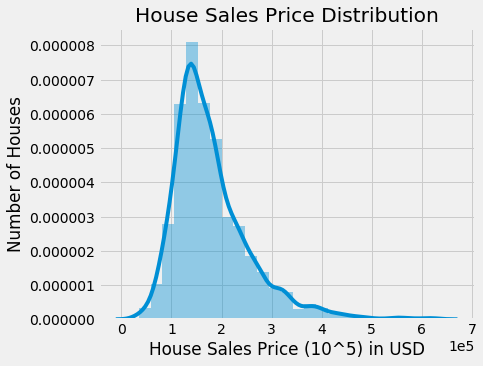

In [87]:
# "SalePrice":

# print(train['SalePrice'].describe())

# Plot graph:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(6, 5))
sns.distplot(df_train.SalePrice, bins = 25)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,1))
plt.xlabel("House Sales Price (10^5) in USD")
plt.ylabel("Number of Houses")
plt.title("House Sales Price Distribution")

# sns.distplot(df_train['SalePrice'], color='g', bins=100, hist_kws={'alpha': 0.4});

### OK.

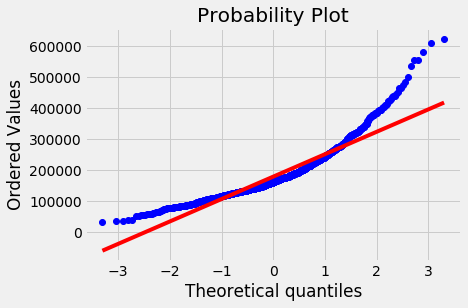

In [88]:
# "SalePrice" Probability plot:
# from scipy import stats 

res = stats.probplot(df_train['SalePrice'], plot=plt)

Skew is: 0.0674665377411
Kurtosis: 0.683932


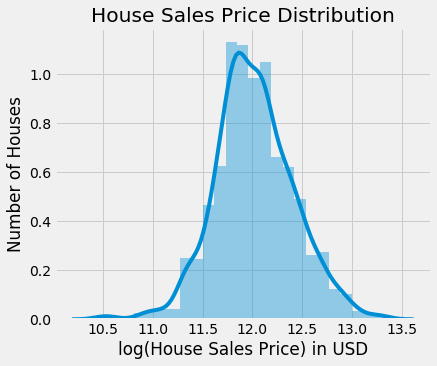

In [89]:
# "SalePrice" log to normalize it:
# https://medium.com/diogo-menezes-borges/project-2-predicting-house-prices-on-kaggle-989f1b0c4ef6

plt.figure(figsize=(6,5))
sns.distplot(np.log(df_train.SalePrice), bins = 25)
plt.xlabel("log(House Sales Price) in USD")
plt.ylabel("Number of Houses")
plt.title("House Sales Price Distribution")

print("Skew is:", np.log(df_train.SalePrice).skew())
print("Kurtosis: %f" % np.log(df_train.SalePrice).kurt())

In [90]:
# "SalePrice" Probability plot with log:
# from scipy import stats 

res = stats.probplot(SalePriceLog, plot=plt)

NameError: name 'SalePriceLog' is not defined

# 3) Modeling the data:

In [ ]:
# Modeling objectives:

# Linear Regression OK
# Ridge Regression OK
# Lasso Regression OK
# Kernel Ridge Regression OK
# Random Forest Regressor NA
# Gradient Boosting Regressor OK
# XGBoost OK

In [ ]:
# A list of the data:

# list(df_train)

In [90]:
# A final analysis of the data:
# # https://www.kaggle.com/mgmarques/houses-prices-complete-solution

def rstr(df, pred=None): 
    obs = df.shape[0]
    types = df.dtypes
    counts = df.apply(lambda x: x.count())
    nulls = df.apply(lambda x: x.isnull().sum())
    distincts = df.apply(lambda x: x.unique().shape[0])
    missing_ration = (df.isnull().sum()/ obs) * 100
    skewness = df.skew()
    kurtosis = df.kurt() 
    print('Data shape:', df.shape)
    
    if pred is None:
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing ration', 'skewness', 'kurtosis']
        str = pd.concat([types, counts, distincts, nulls, missing_ration, skewness, kurtosis], axis = 1)

    else:
        corr = df.corr()[pred]
        str = pd.concat([types, counts, distincts, nulls, missing_ration, skewness, kurtosis, corr], axis = 1, sort=False)
        corr_col = 'corr '  + pred
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing_ration', 'skewness', 'kurtosis', corr_col ]
        
    str.columns = cols
    dtypes = str.types.value_counts()
    print('___________________________\nData types:\n',str.types.value_counts())
    print('___________________________')
    return str

pd.set_option('display.max_rows', 256)
details = rstr(df_train, 'SalePrice')
display(details.sort_values(by='corr SalePrice', ascending=False))

Data shape: (1452, 256)
___________________________
Data types:
 uint8      213
int64       26
float64     12
int32        5
Name: types, dtype: int64
___________________________


,types,counts,distincts,nulls,missing_ration,skewness,kurtosis,corr SalePrice
SalePrice,int64,1452,658,0,0.0,1.578456,3.962323,1.000000
OverallQual,int64,1452,10,0,0.0,0.184821,0.049211,0.802832
GrLivAreaLog,float64,1452,855,0,0.0,-0.109017,0.002924,0.699448
ExterQual,int64,1452,4,0,0.0,0.817770,0.047493,0.699219
KitchenQual,int64,1452,4,0,0.0,0.381773,-0.239365,0.669496
GarageCars,int64,1452,5,0,0.0,-0.340623,0.220201,0.650498
TotalBsmtSF,int64,1452,714,0,0.0,0.487770,1.780763,0.643992
BsmtQual,int32,1452,5,0,0.0,-0.476744,1.246404,0.630880
TotalBathLog,float64,1452,10,0,0.0,-0.316248,-0.569113,0.621579
GarageArea,float64,1452,436,0,0.0,0.796365,1.181530,0.607039


In [91]:
# Defining SalePrice for the modeling:

# Log of SalePrice:
SalePriceLog = np.log1p(df_train.SalePrice)

# Droppping SalePrice from X:
df_train_X = df_train.copy()
df_train_X.drop(columns=["SalePrice"], axis=1, inplace=True) 

# Multivariate Linear Regression:

In [92]:
# Multivariate Linear Regression with data treatment (Prediction results):

# Below is a list of variables with only numerical values (and not year-related):
X = df_train_X
y = SalePriceLog
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 7.997e+04
Date:                Sat, 02 Mar 2019   Prob (F-statistic):               0.00
Time:                        20:31:04   Log-Likelihood:                 1395.0
No. Observations:                1452   AIC:                            -2284.
Df Residuals:                    1199   BIC:                            -947.9
Df Model:                         253                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
LotFrontage                       1.427e-05      0.000      0.138      0.890      -0.000       0.000
LotShape                             0.0061      0.006      0.981      0.327      -0.006       0.018
LandSlope                            0.0086      0.009      0.956      0.339      -0.009       0.026
OverallQual                          0.0397      0.005      8.484      0.000       0.031       0.049
OverallCond                          0.0401      0.004     10.075      0.000       0.032       0.048
YearBuilt                            0.0025      0.000     10.653      0.000       0.002       0.003
YearRemodAdd                         0.0009      0.000      4.090      0.000       0.000       0.001
ExterQual                            0.0081      0.010      0.833      0.405      -0.011       0.027
ExterCond                           -0.0072      0.010     -0.755      0.450      -0.026       0.011
BsmtQual                             0.0113      0.008      1.433      0.152      -0.004       0.027
BsmtCond                            -0.0002      0.010     -0.020      0.984      -0.021       0.020
BsmtExposure                         0.0132      0.004      3.413      0.001       0.006       0.021
BsmtFinType1                         0.0047      0.002      2.077      0.038       0.000       0.009
BsmtFinSF1                        2.025e-05   3.19e-05      0.635      0.526   -4.23e-05    8.28e-05
BsmtFinType2                        -0.0021      0.006     -0.362      0.718      -0.013       0.009
BsmtUnfSF                        -5.091e-05   3.13e-05     -1.627      0.104      -0.000    1.05e-05
TotalBsmtSF                          0.0001   3.45e-05      3.745      0.000    6.15e-05       0.000
HeatingQC                            0.0135      0.004      3.132      0.002       0.005       0.022
CentralAir                           0.0477      0.016      2.937      0.003       0.016       0.080
BedroomAbvGr                        -0.0078      0.006     -1.254      0.210      -0.020       0.004
KitchenAbvGr                        -0.0488      0.027     -1.814      0.070      -0.101       0.004
KitchenQual                          0.0109      0.007      1.484      0.138      -0.004       0.025
Functional                           0.0378      0.005      7.769      0.000       0.028       0.047
FireplaceQu                          0.0014      0.005      0.255      0.799      -0.009       0.012
GarageFinish                         0.0028      0.006      0.501      0.616      -0.008       0.014
GarageCars                           0.0300      0.010      2.934      0.003       0.010       0.050
GarageArea                        7.024e-05   3.54e-05      1.982      0.048    7.22e-07       0.000
GarageQual                           0.0393      0.01

RMSE on Training set : 0.129753996994
RMSE on Test set : 0.162650305028


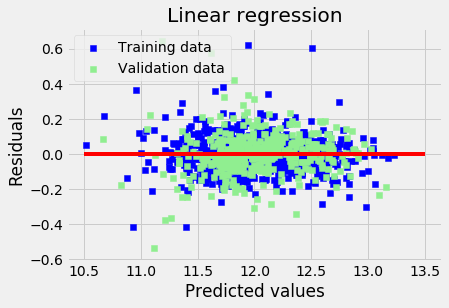

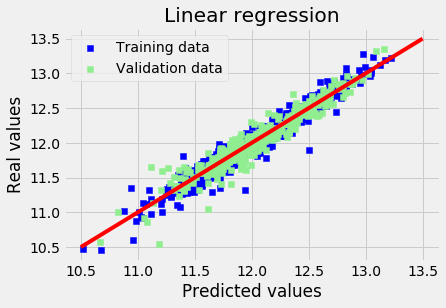

In [92]:
# Multivariate Linear Regression with data treatment (Graph):

# https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset

# from sklearn.model_selection import cross_val_score, train_test_split
# from sklearn.metrics import mean_squared_error, make_scorer
# from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV

# Partition the dataset in train + test sets:
X = df_train_X
y = SalePriceLog
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,
                                                    random_state = 0)

# Define error measure for official scoring : RMSE:
scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring = scorer, 
                                   cv = 10))
    return(rmse)

def rmse_cv_test(model):
    rmse= np.sqrt(-cross_val_score(model, X_test, y_test, scoring = scorer, 
                                   cv = 10))
    return(rmse)

# Linear Regression:
lr = LinearRegression()
lr.fit(X_train, y_train)

# Look at predictions on training and validation set:
print("RMSE on Training set :", rmse_cv_train(lr).mean())
print("RMSE on Test set :", rmse_cv_test(lr).mean())
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

# Plot residuals:
plt.scatter(y_train_pred, y_train_pred - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test_pred - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions:
plt.scatter(y_train_pred, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Ridge Regression:

Ridge Regression train score: 0.93563529829
Ridge Regression test score 0.930467492568


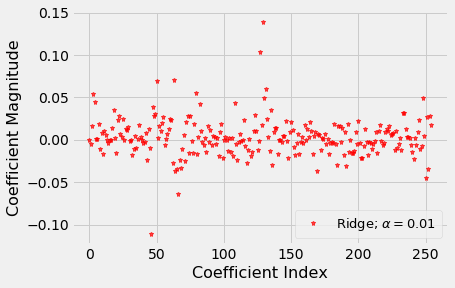

In [109]:
# Ridge Regression (Prediction results):

X = df_train_X
y = SalePriceLog
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,
                                                    random_state = 0)

# Define error measure for official scoring : RMSE:
ridge = Ridge(alpha=14)
ridge.fit(X_train, y_train)

ridge_train_score = ridge.score(X_train, y_train)
ridge_test_score = ridge.score(X_test, y_test)

print ("Ridge Regression train score:", ridge_train_score)
print ("Ridge Regression test score", ridge_test_score)

plt.plot(ridge.coef_,alpha=0.7,linestyle='none',marker='*',markersize=5,color='red',label=r'Ridge; $\alpha = 0.01$',zorder=7) # zorder for ordering the markers
plt.xlabel('Coefficient Index',fontsize=16)
plt.ylabel('Coefficient Magnitude',fontsize=16)
plt.legend(fontsize=13,loc=4)
plt.show()

Best alpha : 10.0
Try again for more precision with alphas centered around 10.0
Best alpha : 9.5
Ridge RMSE on Training set : 0.114769340239
Ridge RMSE on Test set : 0.111742497089


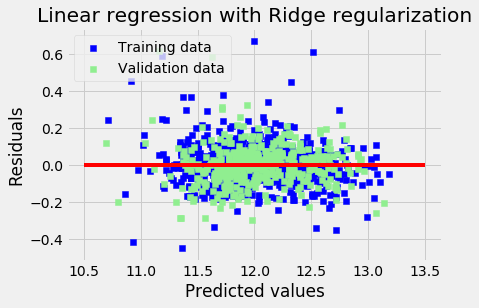

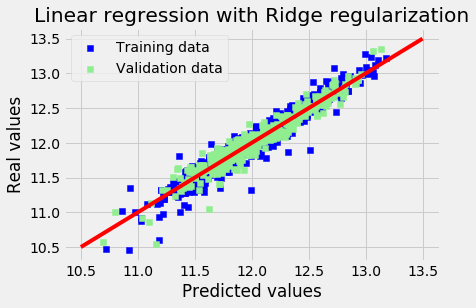

Ridge picked 250 features and eliminated the other 5 features


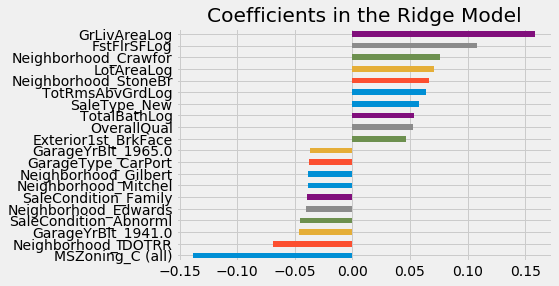

In [107]:
# Ridge Regression (Graph):
# https://towardsdatascience.com/ridge-and-lasso-regression-a-complete-guide-with-python-scikit-learn-e20e34bcbf0b
# https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset

X = df_train_X
y = SalePriceLog
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,
                                                    random_state = 0)

# Define error measure for official scoring : RMSE:
scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring = scorer, 
                                   cv = 10))
    return(rmse)

def rmse_cv_test(model):
    rmse= np.sqrt(-cross_val_score(model, X_test, y_test, scoring = scorer, 
                                   cv = 10))
    return(rmse)

ridge = RidgeCV(alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60, 100])
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

print("Try again for more precision with alphas centered around " + str(alpha))
ridge = RidgeCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, 
                          alpha * .9, alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15,
                          alpha * 1.25, alpha * 1.3, alpha * 1.35, alpha * 1.4], 
                cv = 10)
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

print("Ridge RMSE on Training set :", rmse_cv_train(ridge).mean())
print("Ridge RMSE on Test set :", rmse_cv_test(ridge).mean())
y_train_rdg = ridge.predict(X_train)
y_test_rdg = ridge.predict(X_test)

# Plot residuals:
plt.scatter(y_train_rdg, y_train_rdg - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_rdg, y_test_rdg - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions:
plt.scatter(y_train_rdg, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_rdg, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Plot important coefficients:
coefs = pd.Series(ridge.coef_, index = X_train.columns)
print("Ridge picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")
plt.show()

# Lasso Regression:

In [110]:
# Lasso Regression: Alpha tuning:

X = df_train_X
y = SalePriceLog
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,
                                                    random_state = 0)

lasso = LassoCV(alphas = [0.0001, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 
                          0.3, 0.6, 1], 
                max_iter = 50000, cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

### Best alpha = 0.001

Best alpha : 0.001


In [111]:
# Lasso Regression: Alpha re-tuning:

lasso = LassoCV(alphas = [0.001], max_iter = 5000, cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

print("Try again for more precision with alphas centered around " + str(alpha))
lasso = LassoCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, 
                          alpha * .85, alpha * .9, alpha * .95, alpha, alpha * 1.05, 
                          alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, alpha * 1.35, 
                          alpha * 1.4], 
                max_iter = 50000, cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

### Best alpha = 0.0006

Best alpha : 0.001
Try again for more precision with alphas centered around 0.001
Best alpha : 0.0006


Lasso Regression train score: 0.932849484117
Lasso Regression test score 0.933779420898


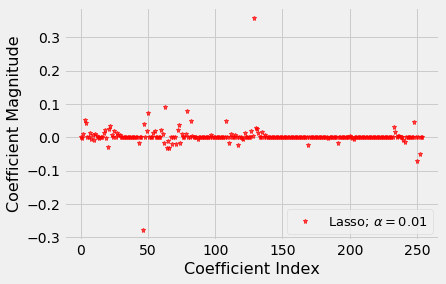

In [112]:
# Lasso Regression (Prediction results):

X = df_train_X
y = SalePriceLog
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,
                                                    random_state = 0)

lasso = Lasso(alpha=0.0006)
lasso.fit(X_train, y_train)

lasso_train_score = lasso.score(X_train, y_train)
lasso_test_score = lasso.score(X_test, y_test)
coeff_used = np.sum(lasso.coef_!=0)

print ("Lasso Regression train score:", lasso_train_score)
print ("Lasso Regression test score", lasso_test_score)

plt.plot(lasso.coef_,alpha=0.7,linestyle='none',marker='*',markersize=5,color='red',label=r'Lasso; $\alpha = 0.01$',zorder=7) # zorder for ordering the markers
plt.xlabel('Coefficient Index',fontsize=16)
plt.ylabel('Coefficient Magnitude',fontsize=16)
plt.legend(fontsize=13,loc=4)
plt.show()

Lasso RMSE on Training set : 0.113232245774
Lasso RMSE on Test set : 0.108073783135


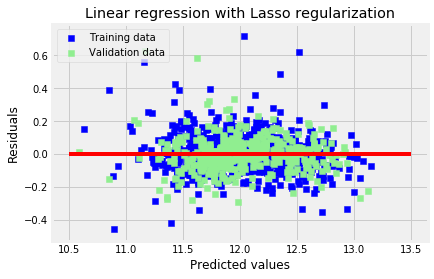

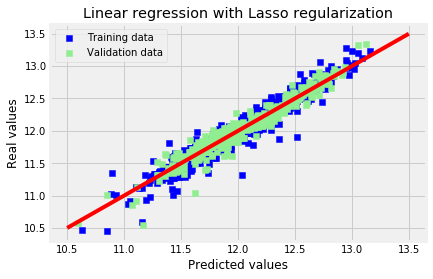

Lasso picked 93 features and eliminated the other 162 features


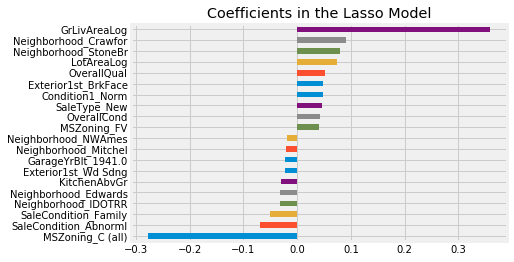

In [98]:
# Lasso Regression (Graph):

X = df_train_X
y = SalePriceLog
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,
                                                    random_state = 0)

# Define error measure for official scoring : RMSE:
scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring = scorer, 
                                   cv = 10))
    return(rmse)

def rmse_cv_test(model):
    rmse= np.sqrt(-cross_val_score(model, X_test, y_test, scoring = scorer, 
                                   cv = 10))
    return(rmse)

lasso = LassoCV(alphas = [0.0006], max_iter = 50000, cv = 10)
lasso.fit(X_train, y_train)

print("Lasso RMSE on Training set :", rmse_cv_train(lasso).mean())
print("Lasso RMSE on Test set :", rmse_cv_test(lasso).mean())
y_train_las = lasso.predict(X_train)
y_test_las = lasso.predict(X_test)

# Plot residuals:
plt.scatter(y_train_las, y_train_las - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_las, y_test_las - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions:
plt.scatter(y_train_las, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_las, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Plot important coefficients:
coefs = pd.Series(lasso.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")
plt.show()

# Kernel Ridge Regression:

Kernel Ridge RMSE on Training set : 0.120713077587
Kernel Ridge RMSE on Test set : 0.118495176691


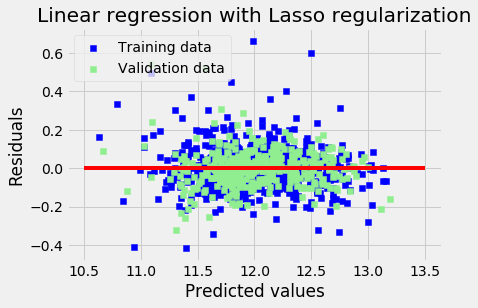

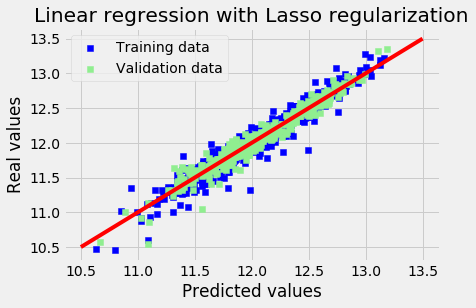

In [100]:
# Kernel Ridge Regression (Graph):
# https://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html

X = df_train_X
y = SalePriceLog
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, 
                                                    random_state=0)

# Define error measure for official scoring : RMSE:
scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring = scorer, 
                                   cv = 10))
    return(rmse)

def rmse_cv_test(model):
    rmse= np.sqrt(-cross_val_score(model, X_test, y_test, scoring = scorer, 
                                   cv = 10))
    return(rmse)

kernel_ridge = KernelRidge(alpha = 1.0, coef0=1, degree=3, gamma=None, kernel='linear', kernel_params=None)
kernel_ridge.fit(X_train, y_train)

print("Kernel Ridge RMSE on Training set :", rmse_cv_train(kernel_ridge).mean())
print("Kernel Ridge RMSE on Test set :", rmse_cv_test(kernel_ridge).mean())
y_train_kr = kernel_ridge.predict(X_train)
y_test_kr = kernel_ridge.predict(X_test)

# Plot residuals:
plt.scatter(y_train_kr, y_train_kr - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_kr, y_test_kr - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions:
plt.scatter(y_train_kr, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_kr, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Random Forest Regressor:

In [119]:
# Mutual Information Regression Metric for Feature Ranking: [ERROR]
# https://www.kaggle.com/adachowicz/house-prices-random-forest-regression-analysis
# http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html

# XGBRegressor:

XGBRegressor RMSE on Training set : 0.127382866399
XGBRegressor RMSE on Test set : 0.12730054641


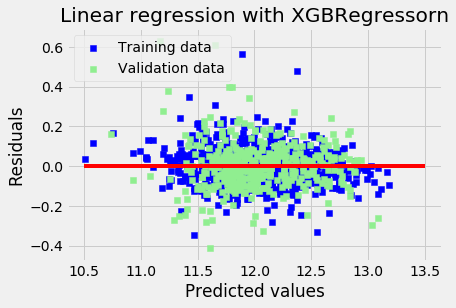

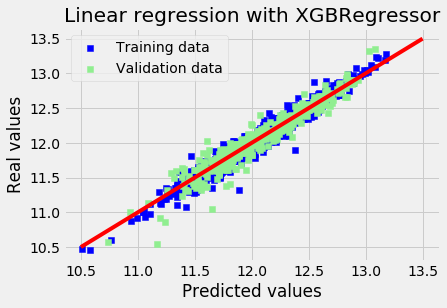

In [93]:
# XGBRegressor:
# http://danielhnyk.cz/how-to-use-xgboost-in-python/

X = df_train_X
y = SalePriceLog
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, 
                                                    random_state=0)

# Define error measure for official scoring : RMSE:
scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring = scorer, 
                                   cv = 10))
    return(rmse)

def rmse_cv_test(model):
    rmse= np.sqrt(-cross_val_score(model, X_test, y_test, scoring = scorer, 
                                   cv = 10))
    return(rmse)

# XGBRegressor:
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)

print("XGBRegressor RMSE on Training set :", rmse_cv_train(xgb_model).mean())
print("XGBRegressor RMSE on Test set :", rmse_cv_test(xgb_model).mean())
y_train_xgb = xgb_model.predict(X_train)
y_test_xgb = xgb_model.predict(X_test)

# Plot residuals:
plt.scatter(y_train_xgb, y_train_xgb - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_xgb, y_test_xgb - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with XGBRegressorn")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions:
plt.scatter(y_train_xgb, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_xgb, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with XGBRegressor")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Gradient Boosting Regressor:

XGBRegressor RMSE on Training set : 0.120016242087
XGBRegressor RMSE on Test set : 0.120210710301


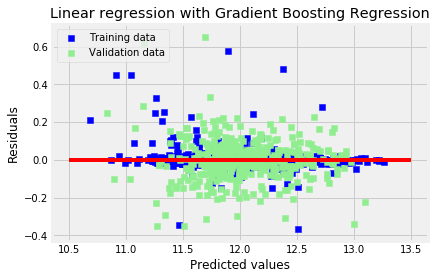

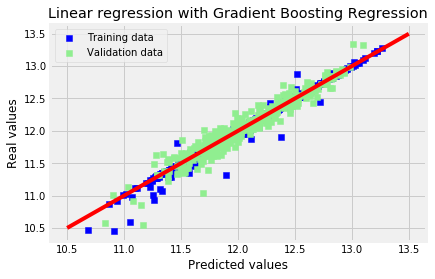

In [96]:
# Gradient Boosting: Feature selection by an embedded method:
# https://github.com/itsmuriuki/Predicting-House-prices/blob/master/house%20prices%20prediction.ipynb

X = df_train_X
y = SalePriceLog
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, 
                                                    random_state=0)

# Define error measure for official scoring : RMSE:
scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring = scorer, 
                                   cv = 10))
    return(rmse)

def rmse_cv_test(model):
    rmse= np.sqrt(-cross_val_score(model, X_test, y_test, scoring = scorer, 
                                   cv = 10))
    return(rmse)

# Gradient Boosting Regression:
gbr_model = GradientBoostingRegressor(loss='huber', learning_rate=0.05, n_estimators=3000,
                                   min_samples_split=10, min_samples_leaf=15,max_depth=4,
                                   random_state=5,max_features='sqrt')
gbr_model.fit(X_train, y_train)

print("XGBRegressor RMSE on Training set :", rmse_cv_train(gbr_model).mean())
print("XGBRegressor RMSE on Test set :", rmse_cv_test(gbr_model).mean())
y_train_gbr = gbr_model.predict(X_train)
y_test_gbr = gbr_model.predict(X_test)

y_train_gbr = gbr_model.predict(X_train)
y_test_gbr = gbr_model.predict(X_test)

# Plot residuals:
plt.scatter(y_train_gbr, y_train_gbr - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_gbr, y_test_gbr - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Gradient Boosting Regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions:
plt.scatter(y_train_gbr, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_gbr, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Gradient Boosting Regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Averaging base model:

In [100]:
# https://github.com/itsmuriuki/Predicting-House-prices/blob/master/house%20prices%20prediction.ipynb

from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

X = df_train_X
y = SalePriceLog
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, 
                                                    random_state=0)

# Define error measure for official scoring : RMSE:
scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring = scorer, 
                                   cv = 10))
    return(rmse)

def rmse_cv_test(model):
    rmse= np.sqrt(-cross_val_score(model, X_test, y_test, scoring = scorer, 
                                   cv = 10))
    return(rmse)

class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models
        ])
        return np.mean(predictions, axis=1)   

# Averaged base models score:

averaged_models = AveragingModels(models = (gbr_model, lasso))

score = rmse_cv_train(averaged_models)
score2 = rmse_cv_test(averaged_models)
print(" Averaged base models train score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
print(" Averaged base models test score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models train score: 0.1110 (0.0184)

 Averaged base models test score: 0.1110 (0.0184)



In [ ]:
# Evaluation of the 

# Conclusion:

In [104]:
# Defining RMSLE evaluation function:
def RMSLE (y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [105]:
# Final training and prediction of the stacked regressor:

averaged_models.fit(df_train.values, y_train) 
stacked_train_pred = averaged_models.predict(df_train.values)
stacked_pred = np.expm1(averaged_models.predict(df_test.values))
print("RMSLE score on the train data:") 
print(RMSLE(y_train,stacked_train_pred))
print("Accuracy score:") 
averaged_models.score(train.values, y_train)

ValueError: Found input variables with inconsistent numbers of samples: [1452, 1016]

In [ ]:
# Submitting the results:

submission = pd.DataFrame({
        "Id": df_test['Id'],
        "SalePrice": np.exp(xgb_pred)
    })
#submission.to_csv('./submission.csv', index=False)